In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')

In [3]:
from medusapy import medusa
from medusapy import medusa_model_n

In [4]:
import json

In [5]:
import glob
path2train = '../resources/train_data/*'
train = []
for name in glob.glob(path2train):
    with open(name) as f:
        train = train + json.load(f)

In [6]:
inactive_color = "#EF476F"
active_color = "#23CE6B"

In [7]:
uno = train[-1]
uno["sample"]

{'fe_struct': {'center_mass_x': 42.0,
  'center_mass_y': -35.5,
  'date': '2022-10-02',
  'distance_to_origin': 54.99,
  'dow': 7,
  'inactive_in_current': True,
  'n_days': 2,
  'n_village_decrease': 0,
  'n_village_increase': 0,
  'n_villages': 2,
  'player_id': 'https://tww.x2.international.travian.com--P--999',
  'prev_distance_to_origin': 54.99,
  'total_population': 485,
  'total_population_decrease': 0,
  'total_population_increase': 0,
  'tribes_summary': {'gauls': 2}},
 'fe_type': 'ndays_n'}

# Prepare train data

### Get only fe_type -> ndays_n

In [8]:
train = [x for x in train if x["sample"]["fe_type"] == "ndays_n"]

In [9]:
train[0]

{'inactive_in_future': False,
 'sample': {'fe_struct': {'center_mass_x': -10.601503759398497,
   'center_mass_y': -3.2205513784461153,
   'date': '2022-10-03',
   'distance_to_origin': 11.08,
   'dow': 1,
   'inactive_in_current': False,
   'n_days': 3,
   'n_village_decrease': 5,
   'n_village_increase': 0,
   'n_villages': 399,
   'player_id': 'https://ts5.x1.international.travian.com--P--1',
   'prev_distance_to_origin': 10.65,
   'total_population': 169851,
   'total_population_decrease': 532,
   'total_population_increase': 364,
   'tribes_summary': {'natars': 399}},
  'fe_type': 'ndays_n'}}

In [10]:
len(train)

230404

### Eval distribution of target classes

In [11]:
future_inactive, future_active = [], []
none = [future_inactive.append(x) if x["inactive_in_future"] == True else future_active.append(x) for x in train]

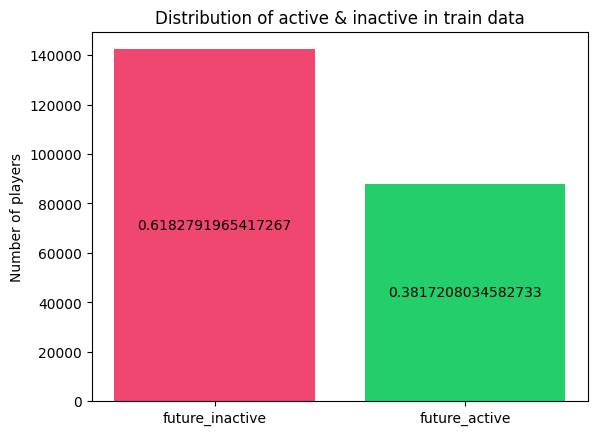

In [12]:
fig, ax = plt.subplots()

x = ["future_inactive", "future_active"]
y = [len(future_inactive), len(future_active)]
perct = [len(future_inactive)/len(train), len(future_active)/len(train)]
colors = [inactive_color, active_color]

p = ax.bar(x, y, color=colors)
ax.bar_label(p, labels=perct, label_type='center', fmt="%.2f%%")

ax.set_ylabel("Number of players")
ax.set_title("Distribution of active & inactive in train data")

plt.show()

### Player Id frequency 

In [13]:
from collections import Counter
ids = [x["sample"]["fe_struct"]["player_id"] for x in train]
p_id_freq = dict(Counter(ids))
appereance = dict(Counter(p_id_freq.values()))
items = list(appereance.items())
items.sort()
x, y = [], []
none = [(x.append(i[0]), y.append(i[1])) for i in items]

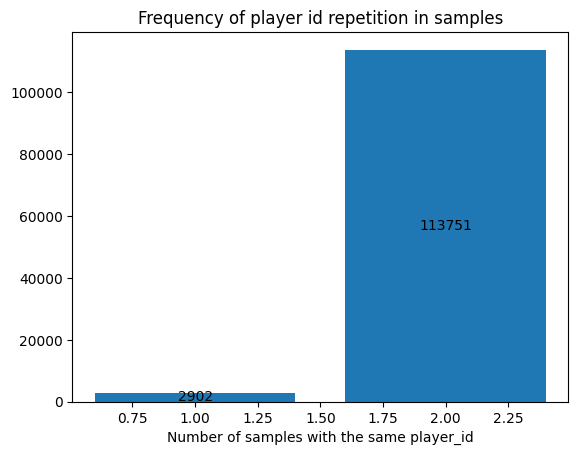

In [14]:
fig, ax = plt.subplots()


p = ax.bar(x, y)
ax.bar_label(p, label_type='center')

#ax.set_ylabel("Number of a player id appereance")
ax.set_xlabel("Number of samples with the same player_id")
ax.set_title("Frequency of player id repetition in samples")

plt.show()

### Prepare the data

In [15]:
def add_y(sample):
    row = sample["sample"]["fe_struct"]
    x = medusa_model_n.prepare_row(row)
    x["y"] = sample["inactive_in_future"]
    return x

In [16]:
data = [add_y(x) for x in train]
data[0]

{'n_days': 3,
 'distance_to_origin': 11.08,
 'prev_distance_to_origin': 10.65,
 'center_mass_x': -10.601503759398497,
 'center_mass_y': -3.2205513784461153,
 'n_villages': 399,
 'n_village_decrease': 5,
 'n_village_increase': 0,
 'total_population': 169851,
 'total_population_decrease': 532,
 'total_population_increase': 364,
 'player_id': 'https://ts5.x1.international.travian.com--P--1',
 'y': False}

In [17]:
from utils import select_players

In [18]:
included = select_players(data, 0.33)

In [19]:
df = pd.DataFrame(data)
df.head(1)

,n_days,distance_to_origin,prev_distance_to_origin,center_mass_x,center_mass_y,n_villages,n_village_decrease,n_village_increase,total_population,total_population_decrease,total_population_increase,player_id,y
0,3,11.08,10.65,-10.601504,-3.220551,399,5,0,169851,532,364,https://ts5.x1.international.travian.com--P--1,False


In [20]:
df.dtypes

n_days                         int64
distance_to_origin           float64
prev_distance_to_origin      float64
center_mass_x                float64
center_mass_y                float64
n_villages                     int64
n_village_decrease             int64
n_village_increase             int64
total_population               int64
total_population_decrease      int64
total_population_increase      int64
player_id                     object
y                               bool
dtype: object

In [21]:
mask = df["player_id"].isin(included)
df_test = df[mask]
df_train = df[~mask]

# Model fitting

### Split sample

In [22]:
from utils import split_x_y_pid

In [23]:
X_train, y_train, p_id_train = split_x_y_pid(df_train)
X_test, y_test, p_id_test = split_x_y_pid(df_test)

### Fit

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=3000, max_depth=5)

In [25]:
%%time
clf.fit(X_train, y_train)

CPU times: user 3min 4s, sys: 23.8 ms, total: 3min 4s
Wall time: 3min 4s


RandomForestClassifier(max_depth=5, n_estimators=3000)

### Evaluation

In [26]:
clf.score(X_test, y_test)

0.9635294736565221

In [27]:
pd.DataFrame(clf.feature_importances_, index=df.columns.to_list()[:-2], columns=["feature importance"]).sort_values("feature importance", ascending=False)

,feature importance
total_population_increase,0.721723
total_population,0.147884
n_villages,0.085361
n_village_increase,0.035766
total_population_decrease,0.003624
prev_distance_to_origin,0.001727
distance_to_origin,0.001651
n_village_decrease,0.000757
center_mass_x,0.000586
n_days,0.000548


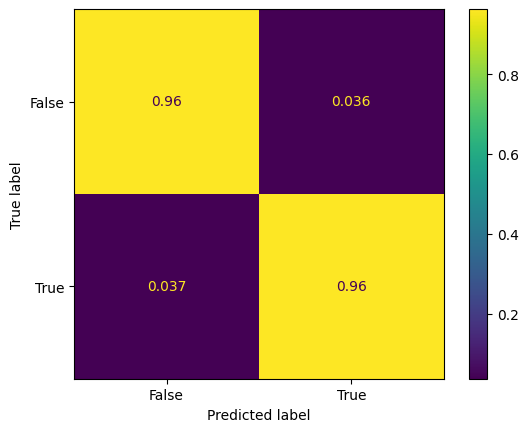

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
_ = disp.plot()

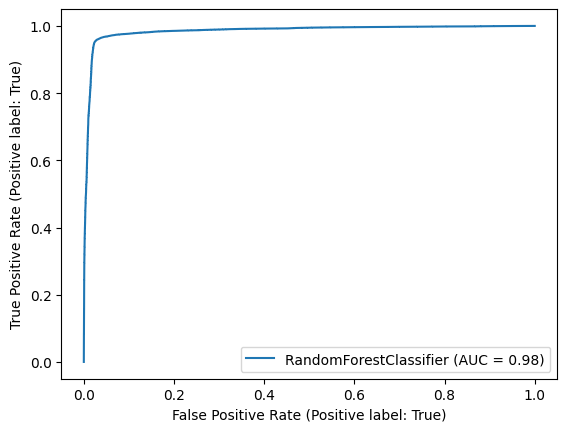

In [29]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [30]:
prediction = clf.predict(X_test)

# Store the model

In [31]:
import pickle
import datetime
now = datetime.datetime.now()
date_time_name = now.strftime("%m_%d_%Y_%H:%M:%S")
pickle.dump(clf, open(f"../trained_models/medusa_model_n__{date_time_name}.pkl", 'wb'))